rectangles[[(184, 270) (339, 425)]]
156


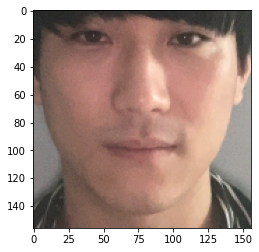

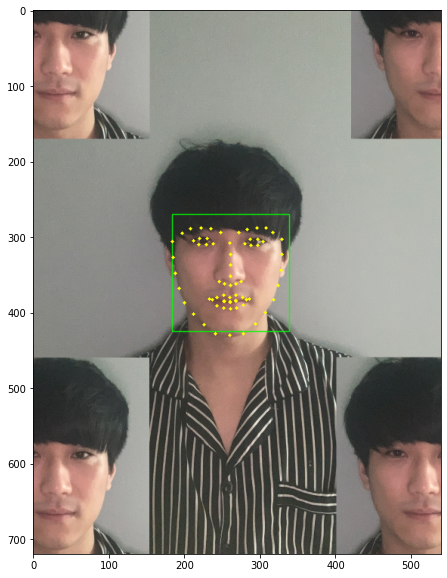

In [14]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
from os.path import join
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

img_dir = './images'
model_dir = './models'

cat_file = 'cat-whiskers.png'
face_file = 'face_multi.jpeg'
model_file = 'shape_predictor_68_face_landmarks.dat'

detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

img_bgr = cv2.imread(join(img_dir,face_file))    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (540,720)) # 너무커서 적정사이즈로 
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# dlib.get_frontal_face_detector 얼굴감지기를 통해서 얼굴 위치의 사각형 박스를 찾음
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print(dlib_rects)
# dlib_rects는 한 사진에서 여러개의 얼굴 오브젝트를 찾을 수 있기때문에 여러개일수있음
# 그렇기때문에 for문을 이용해 찾은 얼굴 위치를 표시함
for dr in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dr.left() # 왼쪽
    t = dr.top() # 위쪽
    r = dr.right() # 오른쪽
    b = dr.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 1, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

# 모델을 shape_predictor 함수를 이용해 가져옴
landmark_predictor = dlib.shape_predictor(join(model_dir,model_file))

list_landmarks = []
for dlib_rect in dlib_rects:
    # 검색이미지 img_rgb와 얼굴의 위치 dlib_rect를 전달해서 얼굴세부 포인트를 찾음
    points = landmark_predictor(img_rgb, dlib_rect)
    """
    map , lambda 문법을 풀어쓰면 하기와같이 쓸수 있음
    list_points = []
    for point in points.parts():
        x = point.x
        y = point.y
        list_points.append((x,y))
    print("list_points:" ,list_points)
    """
    # 모든 landmark의 위치정보를 points 변수에 저장
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # 얼굴 마다 세부포인트들이 있기때문에 list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        # cv2.circle: OpenCV의 원을 그리는 함수
        # img_show 이미지 위 각각의 point에
        # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

for face,marks in zip(dlib_rects, list_landmarks) :
    x = landmark[33][0] # 이미지에서 콧망울 부위의 x값
    y = landmark[33][1] # 이미지에서 콧망울 부위의 y값
    w = h = dlib_rect.width() 
    #w = (dlib_rect.width() // 2) # 털을 얼굴사이즈 절반으로 잡음 / // 다름
    #h = (dlib_rect.height() // 2) # 털을 얼굴사이즈 절반으로 잡음

#img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
img_sticker = cv2.imread(join(img_dir,cat_file)) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
# 정수사이즈로 리사이징 
img_sticker = cv2.resize(img_sticker, (w,h))

print(h)
refined_x = x - (w // 2) # 269 - (78 / 2) = 230
refined_y = y - (h // 2) # 362 - (78 / 2) = 323
#refined_x = x
#refined_y = y

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

    
#print(sticker_area)
#print(img_sticker)

# default: img_show[ 323:(323+78) , 230:(230+78) ]
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show()

#plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
#plt.show()
#print(img_show)
#img_bgr

# 이미지 블렌딩
#test = cv2.addWeighted(img_sticker, 0.5, sticker_area, 0.5, 0)

#img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

